## 🧠 1. Introduction
In the past few years, protein language models based on **transformers** have revolutionized computational biology. Inspired by advances in natural language processing (NLP), these models treat protein sequences like sentences, where amino acids act as words. The power of this approach lies in the ability of transformers to capture long-range dependencies and subtle patterns in amino acid sequences — often correlating with structural or functional motifs.

This tutorial:
- Walks you through the basic concepts behind transformers,
- Introduces several key protein-specific transformer models, and
- Shows how to extract sequence embeddings from such models.

Finally, you will apply them to protein interfaces, evaluating how much can they help in clustering interface residues and how to use them as features in prediction tasks.


## 🔍 2. What is a Transformer?
Transformers are a class of deep learning models that revolutionized natural language processing and are now proving just as powerful in protein biology. Their key innovation is the **self-attention mechanism**, which allows the model to weigh how important each element (e.g., amino acid) in a sequence is relative to every other element. This is especially useful in protein modeling and prediction tasks, where distant residues in sequence can be close in 3D space and functionally interact.

For a great introduction, check out [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) and [Chandra et al.](https://elifesciences.org/articles/82819).

### High-Level View: From Sequences to Meaning
At a high level, a transformer can be seen as a sequence-to-sequence model. Originally used for machine translation, it takes a sequence (like a sentence or a protein sequence) and produces a transformed output (such as a translated sentence or an embedding).

![Alt text](https://jalammar.github.io/images/t/the_transformer_3.png)

The architecture is made of two core parts:

- **Encoder**: Processes the input sequence.
- **Decoder**: Generates the output sequence based on the encoder’s internal representation.

![Alt text](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)

Each encoder/decoder is itself composed of stacked layers (often 6 to 12 in practical models).

In protein models like ESM or ProtT5, **we typically use only the encoder** to generate representations (embeddings) from protein sequences.

### Inside an Encoder: Layer by Layer
Each encoder layer consists of two main subcomponents:

- **Multi-head self-attention** — lets the model compare and connect each token with every other token.
- **Feed-forward neural network** — processes the outputs from the attention step independently at each position.

The decoder also includes an encoder-decoder attention mechanism (important for translation tasks, but often not used in protein-only encoders):

![Alt text](https://jalammar.github.io/images/t/Transformer_decoder.png)

### From Proteins to Tokens: The Input Pipeline

To process a protein sequence with a transformer, we first need to convert it into a machine-readable form. This involves several key steps:

- **Tokenization**: Each amino acid (e.g., `M`, `E`, `T`, `A`, …) is treated as a “token,” similar to a word in a sentence.  

- **Special Tokens**: In addition to amino acids, models often use special tokens to handle sequence boundaries, batch processing, or training objectives:
  - `<cls>`: Marks the start of the sequence; sometimes used to aggregate sequence-level information.
  - `<sep>`: Marks the end of a sequence or separates multiple sequences.
  - `<mask>`: Used in masked language modeling to replace a token that the model should predict.
  - `<pad>`: Used to fill sequences to the same length in a batch for efficient parallel computation.

- **Embedding**: Each token (amino acid or special token) is mapped to a dense vector in a high-dimensional space, typically 512–1024 dimensions. These embeddings allow the model to work with continuous values instead of discrete letters.  

- **Positional Encoding**: Transformers don’t have an inherent sense of sequence order, so a unique positional vector is added to each token embedding to encode its position in the sequence. This ensures that the model can differentiate, for example, the first residue from the last.

This process allows the model to understand not only **what** amino acids are present, but also **where** they occur, while handling batch processing and self-supervised training tasks effectively.

![Alt text](https://iiif.elifesciences.org/lax:82819%2Felife-82819-fig4-v1.tif/full/1234,/0/default.webp)


### Self-Attention: The Transformer's Superpower
The self-attention mechanism enables the model to:
- Evaluate every pair of tokens in the input,
- Learn which residues interact or are contextually important,
- Generate context-aware embeddings for each residue.

This is critical for proteins, where distant residues in the sequence may be functionally or structurally connected.

![Alt text](https://iiif.elifesciences.org/lax:82819%2Felife-82819-fig5-v1.tif/full/1234,/0/default.webp)

#### The Mechanics: Q, K, V
For each token (amino acid), the model computes three vectors:
- **Query (Q)**: What am I looking for?
- **Key (K)**: What do I offer?
- **Value (V)**: What information do I contain?

The attention score is computed as:
```
Attention(Q, K, V) = softmax(Q × Kᵀ / √d_k) × V
```
This computes a weighted sum of values for each position, where the weights depend on how relevant other tokens are.

The result is a new representation for each token that includes information from the entire sequence, i.e. the model’s embedding layers produce **contextualized embeddings** (the internal representations) for each token (i.e., amino acid in a protein sequence).

Thus, the multihead attention in the different layers of each block of the network enables the model to learn rich and useful representations by considering information from tokens at different positions in the input sequence. This makes it particularly effective for modeling proteins and sequence-based predictions, where non-local interactions are common and essential.

### How to Train a Transformer: Self-Supervision
The procedure used to train such models is called **self-supervision** and is typically one of the following two approaches:

- **Autoregressive language modelling**: predict the next token in a sequence, given the previous tokens,
- **Masked language modelling**: predict 'masked' tokens, where certain tokens are removed (typically 15% in an input sequence), and the model is made to predict them using the information available in the unmasked tokens in the sequence.

![Alt text](https://research.nvidia.com/labs/dir/mdm-equal-mm/images/network.jpg)

Transformers trained using the MLM approach have become very popular and successful, because it allows the model to consider the whole input sequence directly instead of everything up until the present point in the sequence.

### 💡 Summary of Key Concepts

| Concept               | Description |
|------------------------|-------------|
| **Tokenization**        | Amino acid sequences are split into tokens (e.g., single-letter residues). |
| **Special Tokens**      | Tokens used to indicate sequence boundaries, padding, or masking: `<cls>` (start), `<sep>` (end), `<mask>` (for prediction), `<pad>` (padding). |
| **Embeddings**          | Each token is mapped to a high-dimensional vector (e.g., 512–1024D). |
| **Positional Encoding** | Injects information about sequence order. |
| **Self-Attention**      | Enables the model to learn dependencies across all positions in the sequence. |
| **Output Representations** | The model outputs a new, context-aware vector for each input token. |

---

By enabling **parallel computation** and modeling of **global context**, transformers form the foundation of today's most powerful protein models, such as **ESM**, **ProtT5**, **AlphaFold**, and **ProteinMPNN**.



## 🧬 3. Overview of Transformer-based Protein Models

Transformer-based protein models apply the architecture of NLP’s most powerful sequence models to biological macromolecules. They are typically trained on **hundreds of millions of protein sequences** (and, in some cases, structural data), learning statistical patterns that relate amino acid identity and position to biological function or structure.

The key output is **context-aware embeddings**: vector representations of residues or whole sequences—where each position's representation incorporates information from the entire sequence via **self-attention**.  

This is important because **proteins are not just linear strings**. Residues far apart in sequence can be close in 3D space and influence each other’s properties. Transformer models can learn these non-local dependencies directly from data.

![Alt text](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*r5_cz0rWW8JPfa5uRWlhCA.png)

---

### 🔹 ProtBERT / ProtT5 (RostLab)
- **Origin & adaptation:** ProtBERT is adapted from **BERT** (encoder-only), while ProtT5 is adapted from **T5** (encoder–decoder). Both were originally designed for human language but re-trained on biological “language” (protein sequences).
- **Training data:** Large UniRef datasets (UniRef50, UniRef100), covering diverse proteins across all domains of life.
- **Model differences:**
  - **ProtBERT:** Encoder-only, good for representation learning and classification tasks.
  - **ProtT5:** Encoder–decoder, more flexible for generation tasks like protein sequence design.
- **Applications:** Function prediction, subcellular localization, binding site identification, remote homology detection.
- **Embedding extraction:** Easily done via [`bio_embeddings`](https://github.com/sacdallago/bio_embeddings) or [Hugging Face models](https://huggingface.co/Rostlab).
- **Key insight:** By treating protein sequences like sentences and amino acids like words, these models learn biochemical “grammar” from massive unlabeled data.

---

### 🔹 ESM (Evolutionary Scale Models) — Meta AI
- **Core idea:** Trained with **masked language modeling** (like BERT), predicting masked residues based on surrounding context.
- **Model variants:**  
  - **ESM-1b:** First large-scale protein Transformer from Meta AI.  
  - **ESM-2:** Scales up to 3B parameters, achieving improved embedding quality.  
  - **ESMFold:** Extends ESM embeddings to **directly predict 3D structures** without MSAs.
- **Advantages:**  
  - No need for MSA input (useful for novel or poorly conserved proteins).  
  - Strong generalization to low-homology regions.
- **Embedding uses:** Structure prediction, functional annotation, sequence clustering, and as graph node features in protein networks.
- **Availability:** Multiple checkpoints available on [Hugging Face](https://huggingface.co/facebook/esm2_t6_8M_UR50D) and via the [ESM GitHub repository](https://github.com/facebookresearch/esm).
- **Key insight:** ESM learns “evolutionary constraints” directly from raw sequences, bypassing the need for explicit alignment in many contexts.

---

### 🔹 ProstT5 (RostLab)
- **Origin & adaptation:** ProstT5 is adapted from **ProtT5-XL-U50**, which itself is based on the **T5** encoder–decoder architecture. It extends ProtT5 by enabling translation between **protein sequence (AA)** and **protein structure (3Di)** representations.  
- **Training data:** Finetuned on **17M proteins** with high-quality AlphaFoldDB structure predictions. Pretraining used billions of sequences (ProtT5-XL-U50) with span corruption.  
- **Tokenization & modalities:**  
  - Amino acids (AA): represented as uppercase tokens.  
  - Protein structures: converted from 3D to **1D 3Di-tokens** (Foldseek); tokens are lowercase to avoid clashes with AA tokens.  
  - Special translation tokens: `<AA2fold>` (sequence → structure) and `<fold2AA>` (structure → sequence).  
- **Applications:**  
  - Embedding extraction from both **AA** and **3Di** sequences.  
  - **Folding**: translation from sequence (AA) to structure (3Di), useful for remote homology detection without explicit 3D modeling.  
  - **Inverse folding**: translation from structure (3Di) to sequence (AA).  
- **Embedding extraction:** Both encoder-only embeddings (efficient in fp16 with batching) and encoder–decoder translation outputs are supported. Unlike ProtT5, ProstT5 can embed **both sequences and structures**.  
- **Key insight:** By aligning the representation of protein **sequences** and **structures** in a shared language model, ProstT5 enables bi-directional translation, unifying sequence and structural information.  
- **Access:** Hosted on [Hugging Face](https://huggingface.co/Rostlab/ProstT5/).  

![Alt text](https://huggingface.co/Rostlab/ProstT5/resolve/main/prostt5_sketch2.png)

---

### 🔹 AlphaFold2 (DeepMind)
- **Architecture:** Combines Transformer-based sequence processing with **geometric deep learning**. The central module—**Evoformer**—applies attention to both sequence (MSA) and pairwise residue features, iteratively refining representations.
- **Inputs:** Multiple sequence alignments (MSAs) and template structures (if available).
- **Outputs:** Full-atom 3D coordinates with confidence scores (pLDDT).
- **Strengths:** State-of-the-art accuracy in CASP14; often matches or exceeds experimental accuracy for soluble proteins.
- **Limitations:**  
  - Cannot easily extract general-purpose sequence embeddings (designed for structure output).  
  - Relies heavily on MSAs (though AlphaFold-Multimer and other variants explore single-sequence use).
- **Data access:** Millions of predictions are already available in the [AlphaFold Protein Structure Database](https://www.alphafold.ebi.ac.uk/).
- **Key insight:** Integrates evolutionary information with learned geometric constraints to solve the “protein folding problem” at scale.

![Alt text](https://i.imgur.com/uhRTxUk.png)

---

### 🔹 ProteinMPNN (Baker Lab)
- **Purpose:** Reverse design—given a fixed 3D backbone, predict an amino acid sequence that will fold into that backbone.
- **Architecture:** Transformer-like message passing over the residue graph, conditioning predictions on 3D coordinates rather than sequence order.
- **Inputs:** Backbone atomic coordinates (N, Cα, C, O atoms).
- **Outputs:** Likely amino acid identities for each position, often ranked by probability.
- **Applications:**  
  - Protein design (engineering novel binders, enzymes, scaffolds).  
  - Testing stability of designed backbones.  
  - Exploring sequence variability for a given structure.
- **Availability:** Open-source via [ProteinMPNN GitHub](https://github.com/dauparas/ProteinMPNN).
- **Key insight:** Complements sequence-based models by conditioning generation on geometry rather than primary sequence alone.

![Alt text](https://camo.githubusercontent.com/d1a1014ab71380dccf048c2f60a54de6954ccc670f321b0ed6bf4d8af1fb3699/68747470733a2f2f646f63732e676f6f676c652e636f6d2f64726177696e67732f642f652f32504143582d317654746e4d42444f71385470484963745566474e38566c3332783549534e63504b6c786a63514a4632713730506c61483275466c6a3241633473336b686e5a71473159787070644d72306954796b2d2f7075623f773d38383926683d333538)

---

### 🧩 Complementary roles of these models:
- **ProtBERT** → Rich, context-aware embeddings from sequence (encoder-only).  
- **ProtT5** → Flexible, context-aware embeddings and sequence generation (encoder–decoder).  
- **ProstT5** → Structure-aware embeddings, incorporating 3D information along with sequence context.  
- **ESM** → Scalable sequence embeddings, structure-free structure prediction (via ESMFold).  
- **AlphaFold2** → Accurate 3D structures from sequence (especially for known families).  
- **ProteinMPNN** → Structure-conditioned sequence generation.  

In practice, you can:
- Extract **sequence embeddings** from ProtBERT, ProtT5, ProstT5, or ESM → Use as **node features** in protein graphs.  
- Predict **structure** with AlphaFold or ESMFold → Convert into 3D graphs for geometry-aware ML.  
- Use **ProteinMPNN** to explore designed sequence space for a given backbone.


## 📦 4. Imports
We start by installing and importing the necessary libraries:
- `torch` for working with PyTorch models
- `transformers` to load a pretrained protein language model (eg., ESM)
- `networkx` for graph creation
- `matplotlib` for basic graph visualization
- `numpy` for handling array data

In [ ]:
import torch
from transformers import EsmTokenizer, EsmModel
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## 🔧 5. Load a Pretrained ESM-2 Model

We use the smallest variant of the ESM-2 model from Meta, which is designed for embedding protein sequences based on their evolutionary information. Larger models are more accurate but also more memory-intensive.


In [ ]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=320, out_features=1280, bias=

## 🧬 6. Example Protein Sequence
We define a short protein sequence. Students can change this to any amino acid sequence of interest (e.g., from UniProt).

In [ ]:
sequence = "MSEQNNTEMTFQIQRIYTKDISFEAPNAPHVFQKDWMA"  # Example: ~40 aa

## 🔡 7. Tokenize the Sequence and Generate Embeddings
The model expects tokenized input. We remove special tokens like [CLS] and [EOS] to retain only per-residue embeddings.


In [ ]:
inputs = tokenizer(sequence, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

token_embeddings = outputs.last_hidden_state.squeeze(0)[1:-1]  # remove special tokens
print(f"Embedding shape: {token_embeddings.shape}")  # [L, D]

Embedding shape: torch.Size([38, 320])


## 📊 8. Convert Embeddings to NumPy for Graph Use
We convert the PyTorch tensor to a NumPy array for easier manipulation and compatibility with graph libraries such as Networkx or Graphein


In [ ]:
embeddings = token_embeddings.numpy()

## 🔗 9. Build the Residue Graph and Store Embeddings as Node Features
We create a graph where each amino acid residue is a node and edges represent backbone (sequential) connectivity. Each node stores its corresponding embedding as a feature.


In [ ]:
G = nx.Graph()
L = embeddings.shape[0]
for i in range(L):
    G.add_node(i, feature=embeddings[i])
    if i < L - 1:
        G.add_edge(i, i + 1)  # backbone connection

## ✅ 10. Exercise

Given a PDB ID, identify interface residues (residues at a protein–protein interaction surface) and compare their embeddings to those of non-interface residues using a protein language model (e.g., ESM-2).

Are there any significant differences?


### Step 1 — Load the Structure and Identify Interface Residues

We’ll use Graphein to parse the structure and annotate interface residues.

In [ ]:
# !pip install graphein

import graphein
graphein.verbose(enabled=False)
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.features.nodes import amino_acid as graphein_nodes
from graphein.protein import edges as graphein_edges
from functools import partial

pdb_id = '1A0G'

# Configure the protein graph
graph_config = ProteinGraphConfig(
    node_metadata_functions = [graphein_nodes.amino_acid_one_hot, graphein_nodes.meiler_embedding],
    edge_construction_functions = [graphein_edges.add_peptide_bonds, partial(graphein_edges.add_distance_threshold,
                                                                             threshold=8.,
                                                                             long_interaction_threshold=2)]
)

# Build the graph from PDB ID
graph = construct_graph(pdb_code=pdb_id, config=graph_config)

# Identify interface residues (here: chain A vs others)
interface_residues = set()
for source, target, kind in graph.edges(data=True):
    if 'distance_threshold' in kind['kind']:
        if source.split(":")[0] == "A" and target.split(":")[0] != "A":
            interface_residues.add(source)
        elif target.split(":")[0] == "A" and source.split(":")[0] != "A":
            interface_residues.add(target)

# Identify all residues in chain A
all_chain_A_residues = [n for n in graph.nodes if n.startswith("A:")]

# Non-interface residues = all in chain A minus interface residues
non_interface_residues = set(all_chain_A_residues) - set(interface_residues)

print(f"Interface residues ({len(interface_residues)}): {interface_residues}")
print(f"Non-interface residues ({len(non_interface_residues)}): {non_interface_residues}")


Output()

Interface residues (114): {'A:ALA:55', 'A:TYR:37', 'A:PHE:133', 'A:VAL:129', 'A:HIS:70', 'A:GLU:46', 'A:ASN:38', 'A:VAL:107', 'A:LEU:147', 'A:GLN:25', 'A:ILE:48', 'A:PRO:63', 'A:LYS:16', 'A:ASN:124', 'A:VAL:36', 'A:SER:96', 'A:PHE:225', 'A:SER:54', 'A:GLU:14', 'A:ARG:120', 'A:LEU:51', 'A:SER:146', 'A:LEU:149', 'A:GLY:23', 'A:THR:61', 'A:THR:84', 'A:ILE:87', 'A:ALA:152', 'A:VAL:261', 'A:TYR:24', 'A:ASP:67', 'A:ARG:257', 'A:ILE:62', 'A:LYS:275', 'A:PHE:69', 'A:LYS:130', 'A:SER:243', 'A:TYR:64', 'A:LEU:231', 'A:VAL:10', 'A:ALA:53', 'A:ARG:59', 'A:LYS:232', 'A:GLU:104', 'A:SER:240', 'A:LYS:68', 'A:THR:274', 'A:GLU:273', 'A:ARG:138', 'A:ARG:141', 'A:PRO:119', 'A:GLN:71', 'A:VAL:44', 'A:LYS:66', 'A:TYR:88', 'A:THR:226', 'A:GLY:262', 'A:THR:106', 'A:VAL:33', 'A:LYS:11', 'A:GLY:1', 'A:TRP:264', 'A:GLU:40', 'A:MET:41', 'A:THR:65', 'A:ILE:137', 'A:ILE:60', 'A:LYS:162', 'A:LEU:140', 'A:ASN:148', 'A:ILE:256', 'A:LYS:145', 'A:ASN:80', 'A:PHE:42', 'A:TYR:2', 'A:ILE:58', 'A:PHE:26', 'A:ILE:144', 'A:G

###Step 2 – Extract embeddings from ESM
We’ll use Meta’s ESM model from the Hugging Face transformers library to embed the sequence.

In [ ]:
# !pip install transformers torch biopython

from transformers import AutoTokenizer, AutoModel
from Bio.PDB.Polypeptide import standard_aa_names, three_to_index
from Bio.Data.IUPACData import protein_letters_3to1
import torch

def three_to_one(resname):
    """Convert 3-letter AA code to 1-letter, unknowns mapped to 'X'"""
    return protein_letters_3to1.get(resname.lower().capitalize(), 'X')

# Load ESM model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model.eval()

# Get protein sequence of chain A from Graphein graph
sequence = "".join([three_to_one(n.split(':')[1]) for n in graph.nodes if n.startswith("A:")])
sequence = sequence.replace("X", "")  # Remove unknown residues

# Tokenize and embed
inputs = tokenizer(sequence, return_tensors="pt", add_special_tokens=True)
with torch.no_grad():
    outputs = model(**inputs)

# ESM embeddings per residue (exclude special tokens)
embeddings = outputs.last_hidden_state[0, 1:-1, :].numpy()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 3 – Compare interface vs. non-interface embeddings
We can project the embeddings into 2D to see if they cluster differently

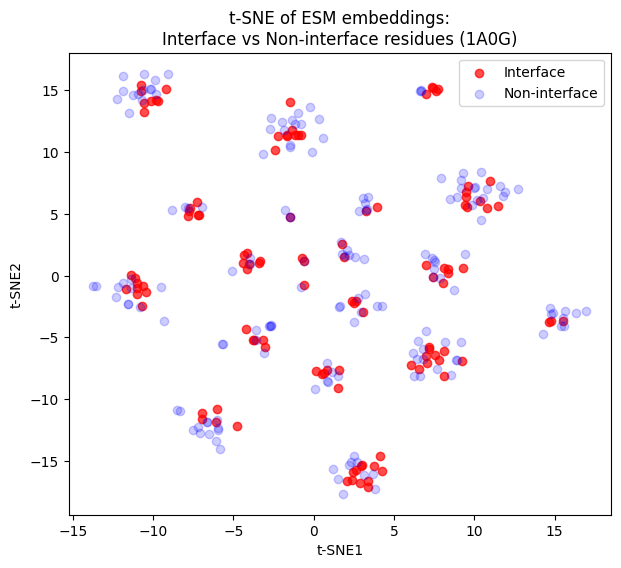

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Map Graphein residue names to sequence positions
chain_A_nodes = [n for n in graph.nodes if n.startswith("A:")]
node_to_index = {n: i for i, n in enumerate(chain_A_nodes)}

# Get indices for interface and non-interface residues
interface_indices = [node_to_index[n] for n in interface_residues]
non_interface_indices = [node_to_index[n] for n in non_interface_residues]

# Extract embeddings
interface_embs = embeddings[interface_indices]
non_interface_embs = embeddings[non_interface_indices]

# Combine embeddings and labels
all_embs = np.vstack([interface_embs, non_interface_embs])
labels = np.array([1]*len(interface_embs) + [0]*len(non_interface_embs))  # 1=interface, 0=non-interface

# t-SNE projection to 2D
tsne = TSNE(n_components=2, init='pca')#, random_state=42, perplexity=30)
emb_tsne = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_tsne[labels==1,0], emb_tsne[labels==1,1], color="red", label="Interface", alpha=0.7)
plt.scatter(emb_tsne[labels==0,0], emb_tsne[labels==0,1], color="blue", label="Non-interface", alpha=0.2)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title(f"t-SNE of ESM embeddings:\nInterface vs Non-interface residues ({pdb_id})")
plt.legend()
plt.show()

## 🔧 11. What about Other Pretrained Models?

[Hugging Face](https://https://huggingface.co/) is a good source of models, but not all are loaded the same way. Why?

Because:

- **Architecture history** → T5 came from NLP (SentencePiece), ESM was designed from scratch for proteins (one-letter tokens).

- **Training data choices** → ProtT5 benefits from subword modeling (compresses long sequences, shares info across motifs), while ESM was trained more like BERT for proteins (direct residues).

- **Compatibility** → Hugging Face needs tokenizer implementations that faithfully reproduce the preprocessing used during training, otherwise embeddings won’t match.

### Let's test ProstT5, which also knows about structure.
[**ProstT5**](https://https://huggingface.co/Rostlab/ProstT5) is a T5 model:
- Uses SentencePiece, a subword tokenization method.
- Is just a protein-trained version of T5, so it reuses the same tokenizer class (T5Tokenizer / AutoTokenizer).
- Sequences are split into subword units (e.g., "MKTVRQ..." → "M", "K", "TV", "RQ", etc., depending on the learned vocab).

Advantage: consistent with NLP T5 models, easy integration in Hugging Face.

In [ ]:
from transformers import T5Tokenizer, T5EncoderModel
# import torch

tokenizer = T5Tokenizer.from_pretrained('Rostlab/ProstT5', do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/ProstT5")

# only GPUs support half-precision currently; if you want to run on CPU use full-precision (not recommended, much slower)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.full() if device=='cpu' else model.half()

# prepare sequence by adding a prefix
# this tells the model what you are planning to encode, as it can also take Foldseek 3Di sequences as input
# if you go from AAs to 3Di (or if you want to embed AAs), you need to prepend "<AA2fold>"
# if you go from 3Di to AAs (or if you want to embed 3Di), you need to prepend "<fold2AA>"
sequence = "<AA2fold>" + sequence

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

## ✅ 12. Repeat the exercise but now use ProstT5 embeddings

Hint: in the Hugging Face page for ProstT5 (link above) there are some more details with examples of how to use the model

In [ ]:
## your code here